<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Setup

In [1]:
#we need Torch 1.12 + and Torchvision 0.13 + for this study
try:
  import torch, torchvision
  assert int(torch.__version__.split(".")[1])>=12, "Torch version should be 1.12 or above"
  assert int(torchvision.__version__.split(".")[1])>=13, "Torch version should be 0.12 or above"
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")
except:
  print("Available libraries not updated, downloading updated libraries")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch, torchvision
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")

Available libraries not updated, downloading updated libraries
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using c

Torch version:2.3.0+cu121
torchvision version:0.18.0+cu121


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

##Importing previously written scripts

In [3]:
%%writefile data_setup.py
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

NUM_WORKERS= os.cpu_count()
def create_dataloaders(
    train_dir: str,
    test_dir:str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size:int,
    num_workers: int=NUM_WORKERS
):

  training_data=datasets.ImageFolder(root=train_dir, transform=train_transform)
  testing_data=datasets.ImageFolder(root=test_dir, transform=test_transform)
  class_names=training_data.classes
  train_dataloader=DataLoader(dataset=training_data,
                              batch_size=batch_size,#sample per dataloader
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory= True)
  test_dataloader=DataLoader(dataset=testing_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory= True)
  return train_dataloader, test_dataloader, class_names


Writing data_setup.py


In [4]:
%%writefile engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
              device: torch.device) -> Tuple[float, float]:
  #putting in training mode
  model.train()
  #setup training loss and training accuracy
  train_loss,train_acc=0,0

  for batch,(x,y) in enumerate(dataloader):
    #send data to target device
    x,y=x.to(device),y.to(device)
    #forward pass
    y_pred=model(x)
    #calculate and accumulate losses
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric for all batches
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #getting average loss and accuracy for each batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
  #putting in eval mode
  model.eval()
  #setup test loss and test accuracy
  test_loss,test_acc=0,0
  #turn on inference context manager
  with torch.inference_mode():
    #loop through dataloader batches
    for batch,(x,y) in enumerate(dataloader):
      #send data to target device
      x,y=x.to(device),y.to(device)
      #forward pass
      test_pred_logits=model(x)
      #calculate and accumulate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      #calculate and accumulate accuracy
      test_pred_labels=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)#can probably also use len(test_pred), not sure both should work i think
  #getting average loss and accuracy for each batch
  test_acc/=len(dataloader)
  test_loss/=len(dataloader)
  return test_loss, test_acc

#defining functions and various required parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs: int,
        device: torch.device) -> Dict[str, list]:
  #create empty results dictionary
  results={"train_loss":[],
           "test_loss":[],
           "train_acc":[],
           "test_acc":[]}
  #looping through train_step() and test_step()
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss, test_acc=test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)
  #print whats happening
    print(
        f"Epoch:{epoch+1}|"
        f"Train Loss:{train_loss:.4f}|"
        f"Training Accuracy: {train_acc:.4f}|"
        f"Test Loss: {test_loss:.4f}|"
        f"Test Accuracy: {test_acc:.4f}"
    )
    #updating result dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
  return results


Writing engine.py


In [5]:
%%writefile utils.py
import torch
from pathlib import Path
def save_model(model:torch.nn.Module,
               target_dir: str,
               model_name:str):
  #creating target directory
  target_dir_path=Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  #creating model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path/model_name

  #save the model state_dict
  print(f"Saving model to:{model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing utils.py


##Device Agnostic Code

In [6]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##Define function to set random seed

In [7]:
#set seeds
def set_seeds(seed:int=69):
  "set seed whenver required before torch operations. Default seed = 69"
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

##Get Data

In [8]:
import requests
import zipfile
from pathlib import Path
import os
def download_data(source:str,
                  destination:str,
                  remove_source:bool=True)->Path:
  #setup path to data folder
  data_path= Path("data/")
  image_path=data_path/destination
  #check if image folder exists or not, if not prepare it
  if image_path.is_dir():
    print(f"{image_path} directory exists")
  else:
    print(f"Didnt find {image_path}, creating...")
    image_path.mkdir(parents=True, exist_ok=True)
    #the datset that will be used is a formatted dataset being taken from a github file, in general, wont get such formatted data
    #download pizza, steak, sushi data in zip file
    target_file=Path(source).name
    with open(data_path/target_file,"wb") as f:
      request = requests.get(source)
      print("Downloading data...")
      f.write(request.content)
    #unzip data
    with zipfile.ZipFile(data_path/target_file,"r") as zip_ref:
      print("Unzipping food_stuff file...")
      zip_ref.extractall(image_path)
    if remove_source:
      os.remove(data_path/target_file)
  return image_path

In [9]:
image_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip", destination='pizza_steak_sushi_20_percent')
image_path

Didnt find data/pizza_steak_sushi_20_percent, creating...
Unzipping food_stuff file...


PosixPath('data/pizza_steak_sushi_20_percent')

In [10]:
!ls data/pizza_steak_sushi_20_percent

test  train


In [11]:
#creating paths to train and test directories
train_dir=image_path/"train"
test_dir=image_path/"test"

##Get EfficientNet B2 Model

In [12]:
def create_effnet_b2(num_classes:int=3):
  #1
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights).to(device)

  #2. freeze all parameters in all layers
  for param in model.parameters():
    param.requires_grad=False
  #3. set random seed
  set_seeds()

  #4. changing classifier layer
  model.classifier= torch.nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                        nn.Linear(in_features=1408,
                                                  out_features=num_classes,
                                                  bias=True).to(device))
  #5. give name
  model.name='effnet_b2'
  print(f"Making EfficientNet_B2")

  return model,weights,transforms

In [13]:
eff_net_b2,eff_net_weights,eff_net_transforms=create_effnet_b2(num_classes=3)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 97.7MB/s]


Making EfficientNet_B2


In [14]:
from torchinfo import summary
summary(eff_net_b2,input_size=(32,3,224,224),col_names=['input_size','output_size','num_params','trainable'], row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

Make dataloaders

In [15]:
import data_setup
train_dataloader_eff_net_b2, test_dataloader_eff_net_b2, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              train_transform=eff_net_transforms,
                                                                              test_transform=eff_net_transforms,
                                                                              batch_size=32)

In [16]:
import engine

#set optimizer
optimizer=torch.optim.Adam(params=eff_net_b2.parameters(),lr=0.001)

#set loss function
loss_fn=torch.nn.CrossEntropyLoss()

#train
eff_net_b2_results=engine.train(model=eff_net_b2,
                                train_dataloader=train_dataloader_eff_net_b2,
                                test_dataloader=test_dataloader_eff_net_b2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1|Train Loss:0.9679|Training Accuracy: 0.5750|Test Loss: 0.7033|Test Accuracy: 0.9284
Epoch:2|Train Loss:0.7297|Training Accuracy: 0.7688|Test Loss: 0.5682|Test Accuracy: 0.9500
Epoch:3|Train Loss:0.5565|Training Accuracy: 0.8667|Test Loss: 0.4957|Test Accuracy: 0.9165
Epoch:4|Train Loss:0.5012|Training Accuracy: 0.8729|Test Loss: 0.4175|Test Accuracy: 0.9688
Epoch:5|Train Loss:0.4238|Training Accuracy: 0.8750|Test Loss: 0.3816|Test Accuracy: 0.9625
Epoch:6|Train Loss:0.3403|Training Accuracy: 0.9208|Test Loss: 0.3494|Test Accuracy: 0.9472
Epoch:7|Train Loss:0.3914|Training Accuracy: 0.9021|Test Loss: 0.3257|Test Accuracy: 0.9688
Epoch:8|Train Loss:0.3803|Training Accuracy: 0.8708|Test Loss: 0.3270|Test Accuracy: 0.9443
Epoch:9|Train Loss:0.2908|Training Accuracy: 0.9375|Test Loss: 0.2766|Test Accuracy: 0.9563
Epoch:10|Train Loss:0.3158|Training Accuracy: 0.9125|Test Loss: 0.2763|Test Accuracy: 0.9688


Plotting Loss Curves

In [17]:
#define function to take the values in th e dictionary and plot
def plot_loss_curves(results):
  train_loss=results['train_loss']
  test_loss=results['test_loss']
  train_accuracy=results['train_acc']
  test_accuracy= results['test_acc']
  epochs=range(len(results['train_loss']))
  plt.figure(figsize=(16,8))

  #plotting loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label='train loss')
  plt.plot(epochs,test_loss, label='test loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()
  #plotting accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label='train accuracy')
  plt.plot(epochs,test_accuracy, label='test accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

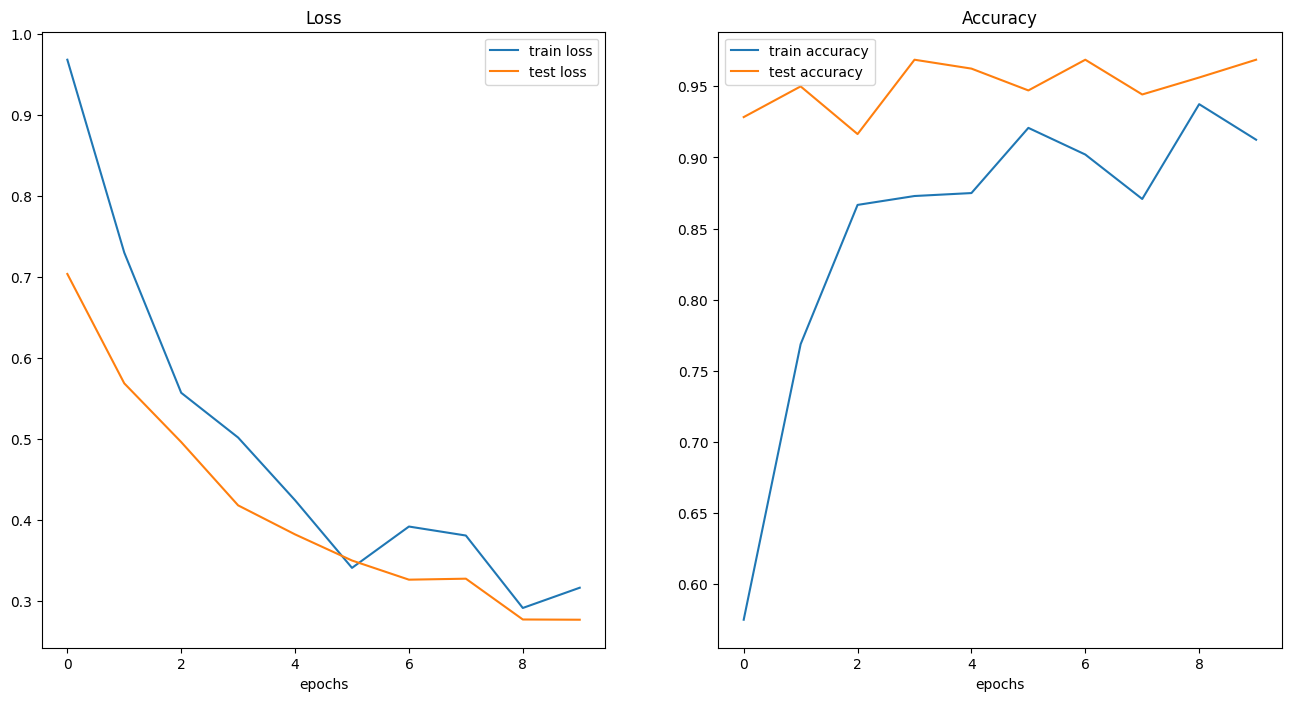

In [18]:
plot_loss_curves(eff_net_b2_results)

Saving Eff_Net_B2 Feature Extractor

In [19]:
import utils
utils.save_model(model=eff_net_b2,
                 target_dir='models',
                 model_name='pretrained_eff_net_b2_feature_extractor.pth')

Saving model to:models/pretrained_eff_net_b2_feature_extractor.pth


Checking Size of Model

In [20]:
from pathlib import Path
eff_net_b2_size=Path('models/pretrained_eff_net_b2_feature_extractor.pth').stat().st_size//(1024*1024)#division converts bytes to MBs
print(f"The Pretrained EfficientNet_B2 feature extractor has size: {eff_net_b2_size} MB")

The Pretrained EfficientNet_B2 feature extractor has size: 29 MB


Counting number of parameters

In [21]:
num_parameters=sum(p.numel() for p in eff_net_b2.parameters())

Important Stats of Eff_Net_B2

In [22]:
eff_net_b2_stats={"test loss": eff_net_b2_results['test_loss'][-1],
                  'test accuracy': eff_net_b2_results['test_acc'][-1],
                  'Number of parameters':num_parameters,
                  'Model Size(MB)': eff_net_b2_size}

eff_net_b2_stats

{'test loss': 0.27627702951431277,
 'test accuracy': 0.96875,
 'Number of parameters': 7705221,
 'Model Size(MB)': 29}

##Getting ViT model

In [23]:
def create_vit_b_16(num_classes:int=3):
  #1
  weights=torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.vit_b_16(weights=weights).to(device)
  #2. freeze all parameters in feature extraction layer
  for param in model.parameters():
    param.requires_grad=False
  #3. set random seed
  set_seeds()

  #4. changing classifier layer
  model.heads= torch.nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                        nn.Linear(in_features=768,
                                                  out_features=num_classes,
                                                  bias=True).to(device))
  #5. give name
  model.name='vit_b_16'
  print(f"Making Vision_Transformer_B16")

  return model,weights,transforms

In [24]:
vit_b16,vit_b16_weights,vit_b16_transforms=create_vit_b_16(num_classes=3)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 132MB/s]


Making Vision_Transformer_B16


In [25]:
from torchinfo import summary
summary(vit_b16,input_size=(32,3,224,224),col_names=['input_size','output_size','num_params','trainable'], row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]         [32, 3]                   768                       Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder (encoder)                                          [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout (dropout)                                     [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential (layers)                                   [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]            [32, 197, 768]            (7,087,872)   

Create dataloaders

In [26]:
import data_setup
train_dataloader_vit_b16, test_dataloader_vit_b16, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              train_transform=vit_b16_transforms,
                                                                              test_transform=vit_b16_transforms,
                                                                              batch_size=32)

Training ViT feature extractor

In [27]:
import engine
#set optimizer
optimizer=torch.optim.Adam(params=vit_b16.parameters(),lr=0.001)

#set loss function
loss_fn=torch.nn.CrossEntropyLoss()

#train
vit_b16_results=engine.train(model=vit_b16,
                             train_dataloader=train_dataloader_vit_b16,
                             test_dataloader=test_dataloader_vit_b16,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=10,
                             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1|Train Loss:0.5261|Training Accuracy: 0.8708|Test Loss: 0.1944|Test Accuracy: 0.9722
Epoch:2|Train Loss:0.2021|Training Accuracy: 0.9417|Test Loss: 0.1103|Test Accuracy: 0.9875
Epoch:3|Train Loss:0.1453|Training Accuracy: 0.9604|Test Loss: 0.0885|Test Accuracy: 0.9875
Epoch:4|Train Loss:0.1316|Training Accuracy: 0.9667|Test Loss: 0.0788|Test Accuracy: 0.9812
Epoch:5|Train Loss:0.1037|Training Accuracy: 0.9708|Test Loss: 0.0709|Test Accuracy: 0.9812
Epoch:6|Train Loss:0.0867|Training Accuracy: 0.9750|Test Loss: 0.0688|Test Accuracy: 0.9812
Epoch:7|Train Loss:0.0759|Training Accuracy: 0.9812|Test Loss: 0.0644|Test Accuracy: 0.9812
Epoch:8|Train Loss:0.0718|Training Accuracy: 0.9792|Test Loss: 0.0607|Test Accuracy: 0.9812
Epoch:9|Train Loss:0.0576|Training Accuracy: 0.9896|Test Loss: 0.0611|Test Accuracy: 0.9812
Epoch:10|Train Loss:0.0501|Training Accuracy: 0.9917|Test Loss: 0.0596|Test Accuracy: 0.9812


Plot loss curves

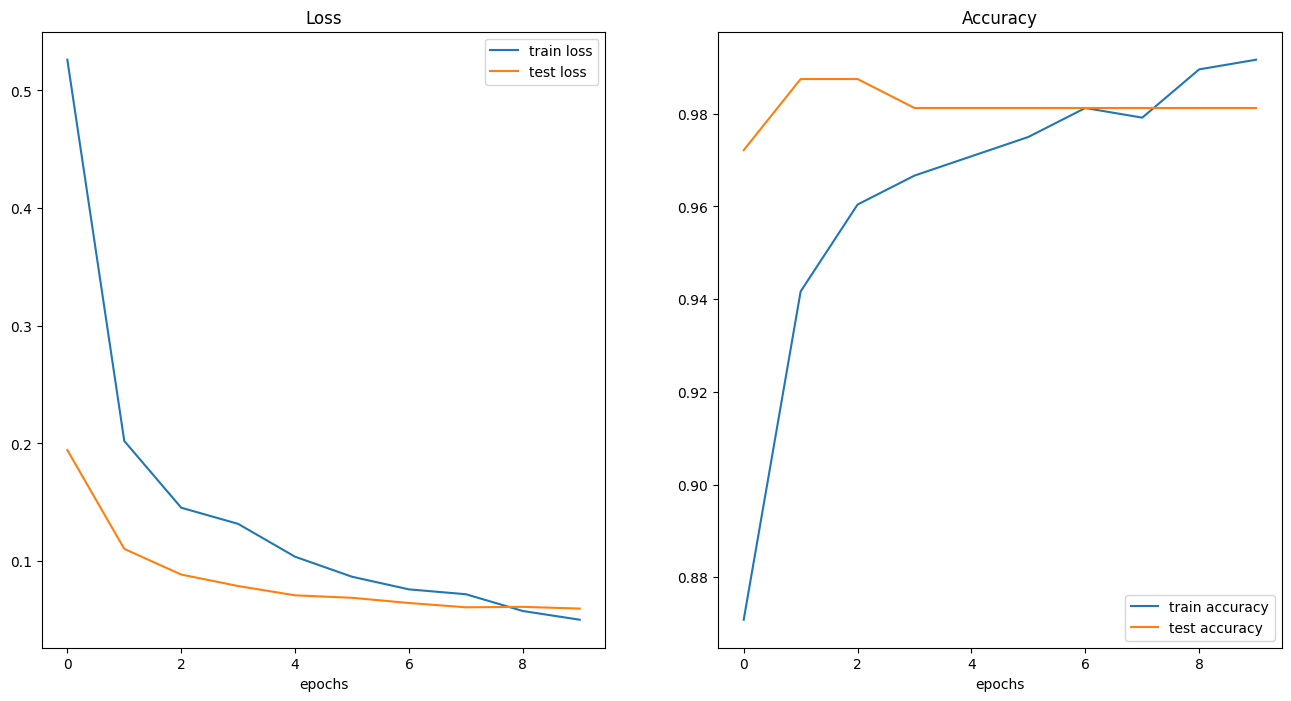

In [28]:
plot_loss_curves(vit_b16_results)

Saving ViT Feature Extractor

In [29]:
import utils
utils.save_model(model=vit_b16,
                 target_dir='models',
                 model_name='pretrained_vit_b16_feature_extractor.pth')

Saving model to:models/pretrained_vit_b16_feature_extractor.pth


Counting Number of Parameters

In [30]:
num_parameters_vit=sum(p.numel() for p in vit_b16.parameters())

Checking Size of ViT_B16

In [31]:
from pathlib import Path
vit_b16_size=Path('models/pretrained_vit_b16_feature_extractor.pth').stat().st_size//(1024*1024)#division converts bytes to MBs

Important Stats of ViT_B16

In [32]:
vit_b16_stats={"test loss": vit_b16_results['test_loss'][-1],
                  'test accuracy': vit_b16_results['test_acc'][-1],
                  'Number of parameters':num_parameters_vit,
                  'Model Size(MB)': vit_b16_size}

vit_b16_stats

{'test loss': 0.0596057815477252,
 'test accuracy': 0.98125,
 'Number of parameters': 85800963,
 'Model Size(MB)': 327}

##Make predictions and time them

In [33]:
#Get list of all test images
from pathlib import Path
print(f"Making list of all images from{test_dir}")
test_images_path=list(Path(test_dir).glob("*/*.jpg"))
test_images_path[:10]

Making list of all images fromdata/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3785667.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg')]

Make function to take input of list of image paths and model and get a dictionary containing info about prediction

In [34]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

#defining function
def pred_and_store(model:torch.nn.Module,image_paths:List[pathlib.Path],transform:torchvision.transforms,class_names:List,device:str)-> List[Dict]:
  pred_list=[]
  for path in tqdm(image_paths):
    #make an empty dictionary
    pred_dict={}

    #put image path and true image class in the dictionary
    pred_dict['image_path']=path
    pred_dict['true class']= path.parent.stem

    #start timer
    start_time=timer()


    #open image
    img=Image.open(path)

    #transform image, add batch dimension, put on target device
    transformed_image=transform(img).unsqueeze(0).to(device)

    #put model on target device
    model.to(device)

    #put model in eval mode
    model.eval()
    with torch.inference_mode():
      #pass image through model
      pred_logits=model(transformed_image)
      #get prediction probability
      pred_prob=torch.softmax(pred_logits,dim=1)
      #get prediction label
      pred_label=torch.argmax(pred_prob,dim=1)
      #get prediction class
      pred_class=class_names[pred_label]

    #end timer and calculate time
    end_time=timer()
    time_elapsed=end_time-start_time
    #put predicted class and probability in the dictionary
    pred_dict['predicted class']=pred_class
    #put probability in cpu and round off to 4 decimal places and then put in dictionary
    pred_dict['prediction probability']=round(pred_prob.max().cpu().item(),4)
    #put time elapsed in dictionary
    pred_dict['time elapsed']=time_elapsed

    #does the predicted class match the true class
    pred_dict['correct']=pred_class==path.parent.stem

    #append dictionary to list
    pred_list.append(pred_dict)

  return pred_list

Call the function pred_and_store for eff_net_b2

In [35]:
#hardcode cpu because gpu might not always be available on every device after deployment
eff_net_b2_pred_list=pred_and_store(model=eff_net_b2,
                                    image_paths=test_images_path,
                                    transform=eff_net_transforms,
                                    class_names=class_names,
                                    device='cpu')
eff_net_b2_pred_list[:1]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
  'true class': 'pizza',
  'predicted class': 'pizza',
  'prediction probability': 0.9452,
  'time elapsed': 0.40657141299999466,
  'correct': True}]

In [36]:
#turn prediction dictionaries into pandas dataframe
import pandas as pd
eff_net_b2_pred_df=pd.DataFrame(eff_net_b2_pred_list)
eff_net_b2_pred_df.head()

,image_path,true class,predicted class,prediction probability,time elapsed,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9452,0.406571,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.6536,0.183340,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,pizza,0.6387,0.187283,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9615,0.168028,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.9800,0.162793,True


In [37]:
#checking how many True and How many False in 'correct' column in our dataframe
eff_net_b2_pred_df['correct'].value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [38]:
#get average of prediction time
avg_prediction_time=round(eff_net_b2_pred_df['time elapsed'].mean(),4)
print(f"Average of prediction time:{avg_prediction_time} seconds")

Average of prediction time:0.1198 seconds


In [39]:
#add average time per prediction to model stats dictionary
eff_net_b2_stats['average prediction time']=avg_prediction_time
eff_net_b2_stats

{'test loss': 0.27627702951431277,
 'test accuracy': 0.96875,
 'Number of parameters': 7705221,
 'Model Size(MB)': 29,
 'average prediction time': 0.1198}

Call the function pred_and_store for ViT

In [40]:
vit_b16_pred_list=pred_and_store(model=vit_b16,
                                 image_paths=test_images_path,
                                 transform=vit_b16_transforms,
                                 class_names=class_names,
                                 device='cpu')
vit_b16_pred_list[:1]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
  'true class': 'pizza',
  'predicted class': 'pizza',
  'prediction probability': 0.9995,
  'time elapsed': 0.7236080519999746,
  'correct': True}]

In [41]:
#turn prediction dictionaries into pandas dataframe
vit_b16_pred_df=pd.DataFrame(vit_b16_pred_list)
vit_b16_pred_df.head()

,image_path,true class,predicted class,prediction probability,time elapsed,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9995,0.723608,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.9986,0.565309,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,pizza,0.9919,0.506909,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9991,0.554888,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.9982,0.543914,True


In [42]:
#checking how many True and How many False in 'correct' column in our dataframe
vit_b16_pred_df['correct'].value_counts()

correct
True     147
False      3
Name: count, dtype: int64

In [43]:
#get average of prediction time
avg_prediction_time=round(vit_b16_pred_df['time elapsed'].mean(),4)
print(f"Average of prediction time:{avg_prediction_time} seconds")

Average of prediction time:0.5799 seconds


In [44]:
#add average time per prediction to model stats dictionary
vit_b16_stats['average prediction time']=avg_prediction_time
vit_b16_stats

{'test loss': 0.0596057815477252,
 'test accuracy': 0.98125,
 'Number of parameters': 85800963,
 'Model Size(MB)': 327,
 'average prediction time': 0.5799}

##Compare model results

In [45]:
#convert both stats dictionaries into pandas dataframe
stats=pd.DataFrame([eff_net_b2_stats,vit_b16_stats])

#add column for displaying model name
stats['model name']=['Eff_Net_B2','ViT_B16']

stats

,test loss,test accuracy,Number of parameters,Model Size(MB),average prediction time,model name
0,0.276277,0.96875,7705221,29,0.1198,Eff_Net_B2
1,0.059606,0.98125,85800963,327,0.5799,ViT_B16


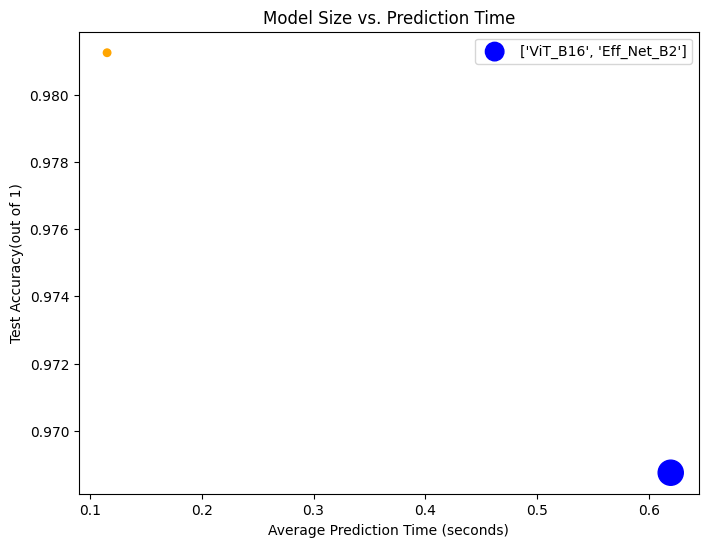

In [46]:
# @title Accuracy vs Prediction Time

import matplotlib.pyplot as plt

data = {
    'average prediction time': [0.6196, 0.1153],
    'Test Accuracy':[0.96875,0.98125],
    'model name': ['ViT_B16', 'Eff_Net_B2']
}

plt.figure(figsize=(8, 6))
plt.scatter( data['average prediction time'],data['Test Accuracy'], c=['blue', 'orange'], s=[327,29], label=data['model name'])
plt.xlabel('Average Prediction Time (seconds)')
plt.ylabel('Test Accuracy(out of 1)')
plt.title('Model Size vs. Prediction Time')
_ = plt.legend()


In [47]:
#make separate dataframe containing ratios between EffNetB2 and ViTB16 in each of each data field in stats dataframe
stats_ratio=pd.DataFrame(data=stats.set_index('model name').loc['Eff_Net_B2']/stats.set_index('model name').loc['ViT_B16'], columns=['EffNetB2 to ViTB16 ratios']).T
stats_ratio

,test loss,test accuracy,Number of parameters,Model Size(MB),average prediction time
EffNetB2 to ViTB16 ratios,4.635071,0.987261,0.089803,0.088685,0.206587


##Using Gradio for Deployment


Installing Gradio

In [48]:
try:
  import gradio as gr
except:
  !pip install gradio
  import gradio as gr

#print gradio model version
print(f"Gradio model version:{gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.1 MB/

Write a function for gradio to convert input (image) to output (predicted class, prediction probability, time taken).

In [49]:
#put effnet to cpu
eff_net_b2.to('cpu')

#checking device
next(iter(eff_net_b2.parameters())).device

device(type='cpu')

In [50]:
from typing import Tuple, Dict
#write a function to take an image as input, use EffNet_B2 to make prediction, get predicted class, prediction probability, and time taken for making prediction
def predict_eff_net_b2(img)->Tuple[Dict,float]:
  #start timer
  start_time=timer()
  #transform image
  img=eff_net_transforms(img).unsqueeze(0)
  #put model in eval mode
  eff_net_b2.eval()
  with torch.inference_mode():
    #pass image through model
    pred_logits=eff_net_b2(img)
    #get prediction probability
    pred_prob=torch.softmax(pred_logits,dim=1)#dim=1 because dimension 0 has batch size, dim 1 has prediction logits
    #get prediction label
    pred_label=torch.argmax(pred_prob,dim=1)

    #make a dictionary of class name and corresponding prediction probability of the class
    prob_dict={class_names[i]:pred_prob[0][i].item() for i in range(len(class_names))}

    #end timer and calculate time
    end_time=timer()
    time_elapsed=round(end_time-start_time,4)

  #return the dictionary and time
  return prob_dict,time_elapsed

In [52]:
#get list of all images from test directory as before and select random image
import random
from pathlib import Path
print(f"Making list of all images from{test_dir}")
test_images_path=list(Path(test_dir).glob("*/*.jpg"))
sample_image=random.sample(test_images_path,k=1)[0]
print(f"Random sample image path:{sample_image}")
#open image and predict using predict() function
img=Image.open(sample_image)
probability_dict, elapsed_time=predict_eff_net_b2(img)
print(f"Prediction probability dictionary:{probability_dict}")
print(f"Time elapsed:{elapsed_time} seconds")

Making list of all images fromdata/pizza_steak_sushi_20_percent/test
Random sample image path:data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg
Prediction probability dictionary:{'pizza': 0.9551295638084412, 'steak': 0.014111134223639965, 'sushi': 0.030759286135435104}
Time elapsed:0.4553 seconds


In [53]:
#create a list of example input images for gradio, take 5 random samples
example_list=[random.sample(test_images_path,k=1)[0] for i in range(5)]
example_list

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2716791.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/476333.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/219196.jpg')]

In [54]:
import gradio as gr

#create title, description and article strings
title="Food Prediction"
description='Takes an image as input and classifies it into sushi, pizza or steak'
article='Created in colab, github link:https://github.com/FrodoBaggins87/Machine_Learning/blob/main/Model_Deployment.ipynb'

#create gradio interface
interface=gr.Interface(fn=predict_eff_net_b2,
                       inputs=gr.Image(type='pil'),
                       outputs=[gr.Label(num_top_classes=3,label='Prediction'),
                                gr.Number(label='Time Elapsed')],
                       examples=example_list,
                       title=title,#title of the demo
                       description=description,#description of the demo
                       article=article)#article is like a reference note

#launch interface
interface.launch(debug=False, #should errors be printed locally?
                 share=True) #should it give a sharable link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2e3a2d781fc467b97c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
